In [1]:
import pathlib
import json
import re

In [2]:
import influxdb
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from odapi.connectors import Irceline
from odapi.settings import settings
settings.logger.setLevel(50)

## Parameters

In [4]:
t0 = pd.Timestamp('2020-06-22 13:00:00', tz='CET').tz_convert('UTC')
t0

Timestamp('2020-06-22 11:00:00+0000', tz='UTC')

In [5]:
t1 = pd.Timestamp.utcnow()
t1

Timestamp('2020-06-22 19:41:37.897821+0000', tz='UTC')

## Irceline Reference

In [6]:
cref = Irceline()

In [7]:
sel = cref.select(sitekey='41', measurekey='PM')

In [8]:
sel.shape

(11, 25)

In [9]:
recs = cref.get_records(sel, start=t0, stop=t1)

In [10]:
dref = recs.merge(sel[['serieid', 'seriekey']]).pivot_table(index='start', columns='seriekey', values='value')

In [11]:
dref.tail()

seriekey,PM-10.0/41B011 (µg/m³),PM-10.0/41MEU1 (µg/m³),PM-10.0/41N043 (µg/m³),PM-10.0/41R001 (µg/m³),PM-10.0/41R012 (µg/m³),PM-10.0/41WOL1 (µg/m³),PM-2.5/41B011 (µg/m³),PM-2.5/41MEU1 (µg/m³),PM-2.5/41N043 (µg/m³),PM-2.5/41R001 (µg/m³),PM-2.5/41R012 (µg/m³)
start,,,,,,,,,,,
2020-06-22 14:00:00+00:00,11.0,14.5,23.5,19.0,20.0,16.0,3.00,12.45,8.40,8.65,10.65
2020-06-22 15:00:00+00:00,13.0,NaN,20.5,20.0,23.5,13.5,6.15,NaN,10.00,8.30,12.90
2020-06-22 16:00:00+00:00,13.5,NaN,21.0,18.0,15.5,13.5,6.80,NaN,9.95,6.45,7.65
2020-06-22 17:00:00+00:00,13.5,NaN,18.5,20.5,26.5,15.5,7.05,NaN,9.00,8.50,13.15
2020-06-22 18:00:00+00:00,11.5,NaN,23.0,19.0,28.0,16.0,4.35,10.55,14.05,7.85,15.85


## SDS Benchmark

In [12]:
with pathlib.Path('C:/Users/admin/udlog/influx.json').open() as fh:
    client = influxdb.InfluxDBClient(**json.load(fh))

In [13]:
client.ping()

'1.8.0'

In [14]:
query = """
SELECT mean(pm25) AS pm25, mean(pm10) AS pm10
FROM "home"
WHERE time >= '{start:}' AND time < '{stop:}'
GROUP BY time(1h)
""".format(start=t0.isoformat(), stop=t1.isoformat())
print(query)


SELECT mean(pm25) AS pm25, mean(pm10) AS pm10
FROM "home"
WHERE time >= '2020-06-22T11:00:00+00:00' AND time < '2020-06-22T19:41:37.897821+00:00'
GROUP BY time(1h)



In [15]:
r = client.query(query).raw['series'][0]

In [16]:
dsds = pd.DataFrame(r['values'], columns=r['columns'])
dsds['time'] = pd.to_datetime(dsds['time'])
dsds = dsds.set_index('time')
dsds.columns = ['PM-2.5/Home (µg/m³)', 'PM-10.0/Home (µg/m³)']
dsds.tail()

,PM-2.5/Home (µg/m³),PM-10.0/Home (µg/m³)
time,,
2020-06-22 15:00:00+00:00,10.145073,22.236008
2020-06-22 16:00:00+00:00,4.691492,17.103264
2020-06-22 17:00:00+00:00,4.602457,17.092630
2020-06-22 18:00:00+00:00,4.308759,15.580612
2020-06-22 19:00:00+00:00,3.997399,14.456481


## Data Merge

In [17]:
df = pd.concat([dref, dsds], axis=1)
df.tail()

,PM-10.0/41B011 (µg/m³),PM-10.0/41MEU1 (µg/m³),PM-10.0/41N043 (µg/m³),PM-10.0/41R001 (µg/m³),PM-10.0/41R012 (µg/m³),PM-10.0/41WOL1 (µg/m³),PM-2.5/41B011 (µg/m³),PM-2.5/41MEU1 (µg/m³),PM-2.5/41N043 (µg/m³),PM-2.5/41R001 (µg/m³),PM-2.5/41R012 (µg/m³),PM-2.5/Home (µg/m³),PM-10.0/Home (µg/m³)
2020-06-22 15:00:00+00:00,13.0,NaN,20.5,20.0,23.5,13.5,6.15,NaN,10.00,8.30,12.90,10.145073,22.236008
2020-06-22 16:00:00+00:00,13.5,NaN,21.0,18.0,15.5,13.5,6.80,NaN,9.95,6.45,7.65,4.691492,17.103264
2020-06-22 17:00:00+00:00,13.5,NaN,18.5,20.5,26.5,15.5,7.05,NaN,9.00,8.50,13.15,4.602457,17.092630
2020-06-22 18:00:00+00:00,11.5,NaN,23.0,19.0,28.0,16.0,4.35,10.55,14.05,7.85,15.85,4.308759,15.580612
2020-06-22 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.997399,14.456481


## Render

In [18]:
remeas = re.compile('([\w\-\.]{2,8})/.*(\(.*\))')
resite = re.compile('/([\w]{4,6}) ')

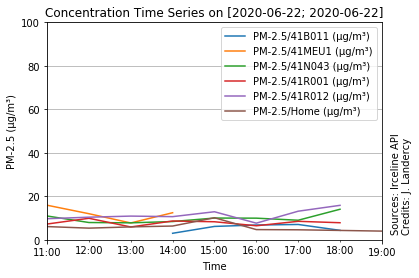

In [19]:
fig, axe = plt.subplots()
axe = df.filter(regex='2.5').plot(ax=axe)
axe.legend(bbox_to_anchor=(1,1))
axe.set_ylim([0, 100])
axe.grid()
labels = [s.get_text() for s in axe.get_legend().get_texts()]
axe.set_title("Concentration Time Series on [{:%Y-%m-%d}; {:%Y-%m-%d}]".format(t0, t1))
axe.set_xlabel("Time")
axe.set_ylabel('{} {}'.format(*remeas.search(labels[0]).groups()))
_ = fig.text(0.92, 0.15, "Sources: Irceline API\nCredits: J. Landercy", rotation=90)

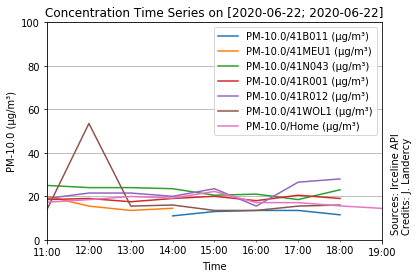

In [20]:
fig, axe = plt.subplots()
axe = df.filter(regex='10.0').plot(ax=axe)
axe.legend(bbox_to_anchor=(1,1))
axe.set_ylim([0, 100])
axe.grid()
labels = [s.get_text() for s in axe.get_legend().get_texts()]
axe.set_title("Concentration Time Series on [{:%Y-%m-%d}; {:%Y-%m-%d}]".format(t0, t1))
axe.set_xlabel("Time")
axe.set_ylabel('{} {}'.format(*remeas.search(labels[0]).groups()))
_ = fig.text(0.92, 0.15, "Sources: Irceline API\nCredits: J. Landercy", rotation=90)

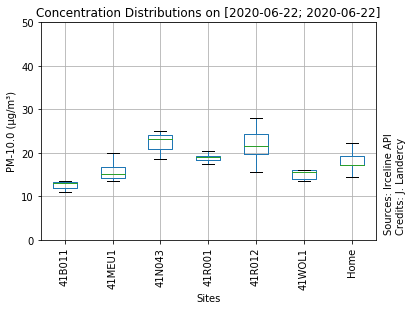

In [21]:
fig, axe = plt.subplots()
axe = df.filter(regex='10.0').boxplot(rot=90, ax=axe)
axe.set_ylim([0, 50])
labels = [s.get_text() for s in axe.get_xticklabels()]
axe.set_xticklabels([resite.search(s).group(1) for s in labels])
axe.set_title("Concentration Distributions on [{:%Y-%m-%d}; {:%Y-%m-%d}]".format(t0, t1))
axe.set_xlabel("Sites")
axe.set_ylabel('{} {}'.format(*remeas.search(labels[0]).groups()))
_ = fig.text(0.92, 0.15, "Sources: Irceline API\nCredits: J. Landercy", rotation=90)

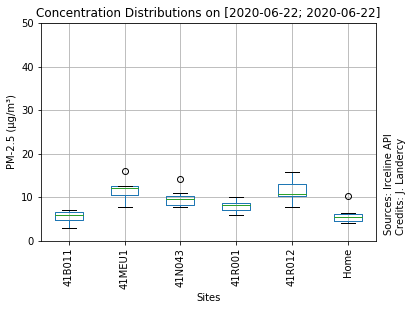

In [22]:
fig, axe = plt.subplots()
axe = df.filter(regex='2.5').boxplot(rot=90, ax=axe)
axe.set_ylim([0, 50])
labels = [s.get_text() for s in axe.get_xticklabels()]
axe.set_xticklabels([resite.search(s).group(1) for s in labels])
axe.set_title("Concentration Distributions on [{:%Y-%m-%d}; {:%Y-%m-%d}]".format(t0, t1))
axe.set_xlabel("Sites")
axe.set_ylabel('{} {}'.format(*remeas.search(labels[0]).groups()))
_ = fig.text(0.92, 0.15, "Sources: Irceline API\nCredits: J. Landercy", rotation=90)